In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime, timedelta
import json
from math import ceil
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from models.qp.qpercent import QPercent
from util.batcher import Batcher
from util.stock_loader import Loader

In [3]:
!ls ../models/qp

__pycache__ data        qpercent.py


In [4]:
N_YEARS = 50
N_CUTS = 4
N_DAYS = int(round(365.25 * N_YEARS))
TODAY = (datetime.now() + timedelta(1)).date()
START = str(TODAY - timedelta(N_DAYS))  # '1996-01-01' #
START, TODAY

('1972-04-17', datetime.date(2022, 4, 17))

[0.46566129 0.2213282  0.10519701 0.05       0.02376493 0.01129544
 0.00536871]


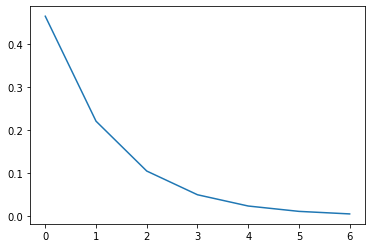

In [5]:
SDS = 0.05 * (0.8 ** np.linspace(-10, 10, 7))
print(SDS)
plt.plot(SDS);

In [6]:
SD = SDS[(TODAY.weekday() + 1) % 7] # 0 (largest SD) on Sat
SD 

0.46566128730773904

In [7]:
DATA = '../models/qp/data'
SYMBOLS = [
    'AAPL', 'ABMD', 'ABNB', 'AMD', 'AMZN', 'ANET', 'APPH', 'AXON',
    'BROS', 'BYND', 'CHWY', 'COIN', 'COUR', 'CRWD', 'DDOG', 'DKNG',
    'DOCU', 'DUOL', 'EDIT', 'ETSY', 'FLGT', 'FUV', 'FVRR', 'GH', 'GMED',
    'GOOG', 'INTG', 'ISRG', 'JD', 'LSPD', 'LULU','MDB', 'MELI', 'MNST',
    'MSFT', 'MTCH', 'NVCR', 'NVDA', 'NYT', 'OKTA', 'OPEN', 'PANW',
    'PINS', 'PTON', 'QDEL', 'RBLX', 'RDFN', 'RGEN', 'ROKU', 'SE',
    'SHOP', 'SPLK', 'SQ', 'TASK', 'TDOC', 'TEAM', 'TREX', 'TTD', 'TTWO',
    'TWLO', 'TWTR', 'UPST', 'VEEV', 'WK', 'XPEV', 'ZEN', 'ZNGA']
INDICES = [
    '^GSPC', # S&P 500
    '^IXIC', # Nasdaq
    '^NYA',  # NY Stock Exchange (total)
    '^W5000'] # Wilshire 5k
len(SYMBOLS)

67

In [8]:
#batcher = Batcher(SYMBOLS, INDICES)
#batch = batcher.get_batch_from_weekday(TODAY.weekday())
#batch

In [9]:
cols = [
    (first, second)
    for first in ['Value', 'Close', 'High', 'Low', 'Open'] 
    for second in ['mine1', 'mine2']]
cols

[('Value', 'mine1'),
 ('Value', 'mine2'),
 ('Close', 'mine1'),
 ('Close', 'mine2'),
 ('High', 'mine1'),
 ('High', 'mine2'),
 ('Low', 'mine1'),
 ('Low', 'mine2'),
 ('Open', 'mine1'),
 ('Open', 'mine2')]

In [10]:
mine = pd.read_csv('../data/mine.csv')
#mine.mine1.iloc[-300:] = 8.1
mine.index = pd.to_datetime(mine['Date'])
mine.drop(columns='Date', inplace=True)
mine['cmine1'] = mine.mine1
mine['cmine2'] = mine.mine2
mine['hmine1'] = mine.mine1
mine['hmine2'] = mine.mine2
mine['lmine1'] = mine.mine1
mine['lmine2'] = mine.mine2
mine['omine1'] = mine.mine1
mine['omine2'] = mine.mine2
mine.columns = pd.MultiIndex.from_tuples(cols)
mine.tail()

Value                Close                 High            \
                mine1     mine2      mine1     mine2      mine1     mine2   
Date                                                                        
2022-04-08  19.043186  7.402860  19.043186  7.402860  19.043186  7.402860   
2022-04-11  18.852863  7.262342  18.852863  7.262342  18.852863  7.262342   
2022-04-12  18.689837  7.176103  18.689837  7.176103  18.689837  7.176103   
2022-04-13  19.243916  7.359597  19.243916  7.359597  19.243916  7.359597   
2022-04-14  18.657302  7.120408  18.657302  7.120408  18.657302  7.120408   

                  Low                 Open            
                mine1     mine2      mine1     mine2  
Date                                                  
2022-04-08  19.043186  7.402860  19.043186  7.402860  
2022-04-11  18.852863  7.262342  18.852863  7.262342  
2022-04-12  18.689837  7.176103  18.689837  7.176103  
2022-04-13  19.243916  7.359597  19.243916  7.359597  
2022-04-14  18.657302  7.120408  18.657302  7.120408

In [11]:
#batch = SYMBOLS + INDICES # run all
batch = INDICES
stock_loader = Loader(batch, START, str(TODAY), verbose=True)
data = stock_loader.download(append=mine)

[*********************100%***********************]  4 of 4 completed
Generating derived columns...
   ...^GSPC
   ...^IXIC
   ...^NYA
   ...^W5000
   ...mine1
   ...mine2


In [12]:
data.head()

Value                                      Close              \
        ^GSPC       ^IXIC        ^NYA ^W5000       ^GSPC       ^IXIC   
0  109.510002  133.740005  646.369995    NaN  109.510002  133.740005   
1  109.769997  134.100006  647.539978    NaN  109.769997  134.100006   
2  109.199997  132.679993  643.940002    NaN  109.199997  132.679993   
3  109.040001  132.860001  642.880005    NaN  109.040001  132.860001   
4  108.889999  133.009995  642.039978    NaN  108.889999  133.009995   

                            High              ... DayToDayChange  \
         ^NYA ^W5000       ^GSPC       ^IXIC  ...         ^W5000   
0  646.369995    NaN  110.220001  133.740005  ...            NaN   
1  647.539978    NaN  110.639999  134.100006  ...            NaN   
2  643.940002    NaN  110.349998  132.679993  ...            NaN   
3  642.880005    NaN  109.690002  132.860001  ...            NaN   
4  642.039978    NaN  109.919998  133.009995  ...            NaN   

  OvernightChange LogValue IntradayChange DayToDayChange OvernightChange  \
           ^W5000    mine1          mine1          mine1           mine1   
0             NaN      NaN            NaN            NaN             NaN   
1             NaN      NaN            NaN            NaN             NaN   
2             NaN      NaN            NaN            NaN             NaN   
3             NaN      NaN            NaN            NaN             NaN   
4             NaN      NaN            NaN            NaN             NaN   

  LogValue IntradayChange DayToDayChange OvernightChange  
     mine2          mine2          mine2           mine2  
0      NaN            NaN            NaN             NaN  
1      NaN            NaN            NaN             NaN  
2      NaN            NaN            NaN             NaN  
3      NaN            NaN            NaN             NaN  
4      NaN            NaN            NaN             NaN  

[5 rows x 55 columns]

In [13]:
data['Date'].tail()

12605   2022-04-08
12606   2022-04-11
12607   2022-04-12
12608   2022-04-13
12609   2022-04-14
Name: Date, dtype: datetime64[ns]

In [14]:
data.index = pd.to_datetime(data['Date'])
data.head()

Value                                      Close              \
                 ^GSPC       ^IXIC        ^NYA ^W5000       ^GSPC       ^IXIC   
Date                                                                            
1972-04-17  109.510002  133.740005  646.369995    NaN  109.510002  133.740005   
1972-04-18  109.769997  134.100006  647.539978    NaN  109.769997  134.100006   
1972-04-19  109.199997  132.679993  643.940002    NaN  109.199997  132.679993   
1972-04-20  109.040001  132.860001  642.880005    NaN  109.040001  132.860001   
1972-04-21  108.889999  133.009995  642.039978    NaN  108.889999  133.009995   

                                     High              ... DayToDayChange  \
                  ^NYA ^W5000       ^GSPC       ^IXIC  ...         ^W5000   
Date                                                   ...                  
1972-04-17  646.369995    NaN  110.220001  133.740005  ...            NaN   
1972-04-18  647.539978    NaN  110.639999  134.100006  ...            NaN   
1972-04-19  643.940002    NaN  110.349998  132.679993  ...            NaN   
1972-04-20  642.880005    NaN  109.690002  132.860001  ...            NaN   
1972-04-21  642.039978    NaN  109.919998  133.009995  ...            NaN   

           OvernightChange LogValue IntradayChange DayToDayChange  \
                    ^W5000    mine1          mine1          mine1   
Date                                                                
1972-04-17             NaN      NaN            NaN            NaN   
1972-04-18             NaN      NaN            NaN            NaN   
1972-04-19             NaN      NaN            NaN            NaN   
1972-04-20             NaN      NaN            NaN            NaN   
1972-04-21             NaN      NaN            NaN            NaN   

           OvernightChange LogValue IntradayChange DayToDayChange  \
                     mine1    mine2          mine2          mine2   
Date                                                                
1972-04-17             NaN      NaN            NaN            NaN   
1972-04-18             NaN      NaN            NaN            NaN   
1972-04-19             NaN      NaN            NaN            NaN   
1972-04-20             NaN      NaN            NaN            NaN   
1972-04-21             NaN      NaN            NaN            NaN   

           OvernightChange  
                     mine2  
Date                        
1972-04-17             NaN  
1972-04-18             NaN  
1972-04-19             NaN  
1972-04-20             NaN  
1972-04-21             NaN  

[5 rows x 55 columns]

In [15]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock or x[0] == 'Date']]
    first_value = sub.Value[stock][sub.Value[stock].notna()].index[0]
    sub = sub.loc[first_value:, :]
    sub.index = range(sub.shape[0])
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    return sub

In [16]:
def str_to_tuple(s):
    s = s[1:-1]
    return tuple([float(x) for x in s.split(', ')])

str_to_tuple('(0.123, 0.456)')

(0.123, 0.456)

In [17]:
def read_best_params(stock):
    try:
        with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'r') as f:
            params = json.load(f)
        for k in params:
            params[k]['q_params'] = {
                str_to_tuple(k): v 
                for k, v in params[k]['q_params'].items()}
        best_returns = {k: params[k]['best_return'] for k in params}
        print('Loaded current best.')
        return params, best_returns
    except FileNotFoundError:
        print('No saved data. Initialized as None')
        return None, None
    except:
        print(
            f'Unexpected error getting {stock} data. Initialized as '
            f'None.')

In [18]:
def get_best_param_set(qp):
    best_param_set = qp.best_param_set
    for method in best_param_set:
        best_param_set[method]['best_return'] = qp.best_returns[method]
        # stringify tuple keys:
        best_param_set[method]['q_params'] = {
            str(k): v 
            for k, v in best_param_set[method]['q_params'].items()}
    return best_param_set

In [19]:
def save_best_param_set(best_param_set, stock):
    print(f'Saving {stock} params...')
    with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'w') as f:
        json.dump(best_param_set, f)

In [20]:
SDS

array([0.46566129, 0.2213282 , 0.10519701, 0.05      , 0.02376493,
       0.01129544, 0.00536871])

SD: 0.2213282



----------------------------------------------------------------------
                                 ^GSPC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 37.92272964095147
Refitting current best...
Current best ma returns: 48.01985979834639
Fraction Invested: 0.9999997422331914
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 37.92272964095147
Refitting current best...
Current best ew_ma returns: 48.98540961747846
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 180


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 37.92272964095147
Refitting current best...
Fraction Invested: 1
Beginning random search..

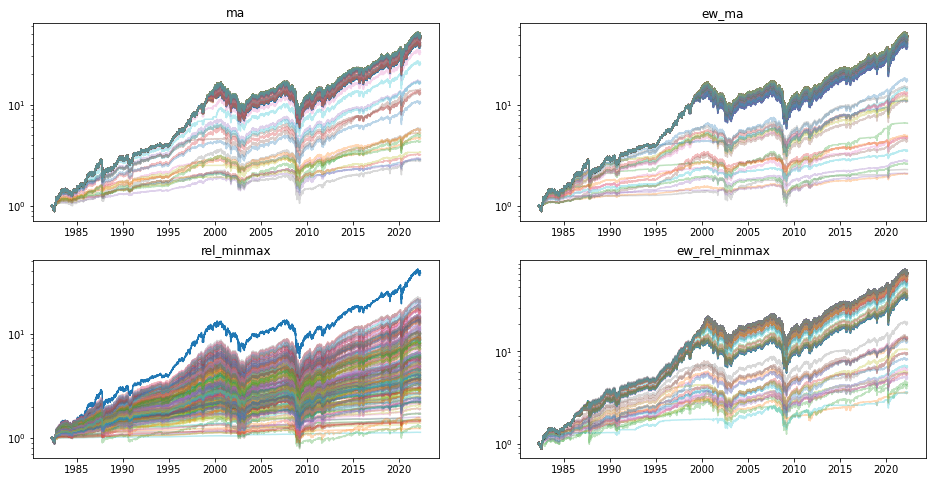

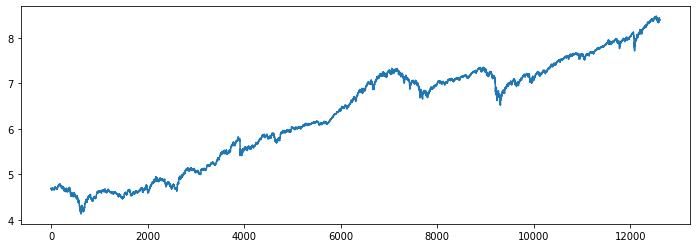

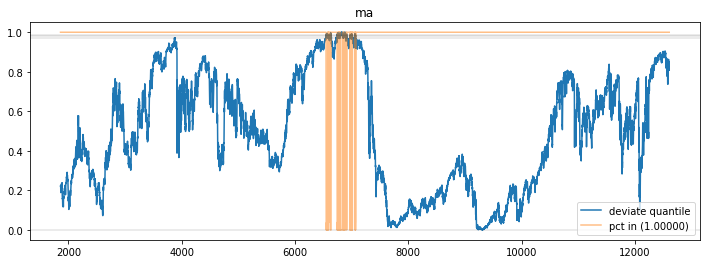

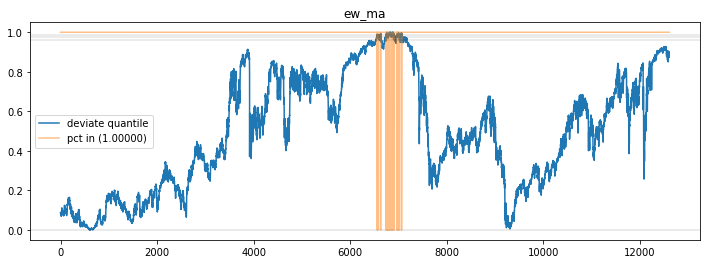

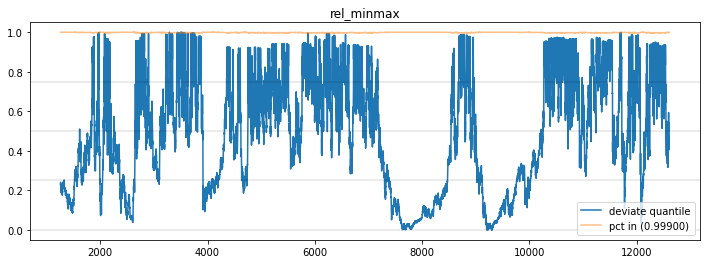

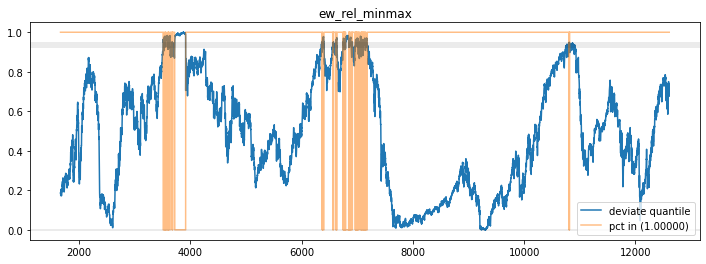

Saving ^GSPC params...



----------------------------------------------------------------------
                                 ^IXIC
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 74.00410069904046
Refitting current best...
Current best ma returns: 112.93697788290159
Fraction Invested: 0.9999925274752438
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 74.00410069904046
Refitting current best...
Fraction Invested: 1
Beginning random search...
Round: 20
No best to adjust. Continuing random
Beginning random search...
Round: 180


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 74.00410069904046
Refitting current best...
Fraction Invested: 1
Beginning random search...
R

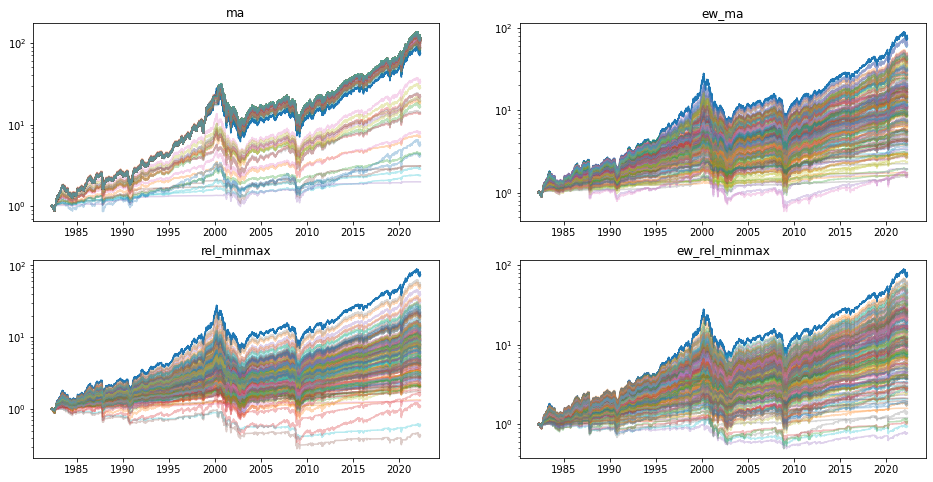

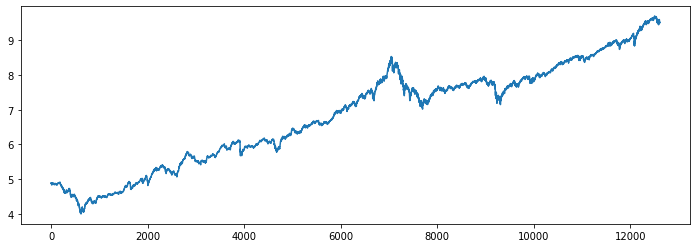

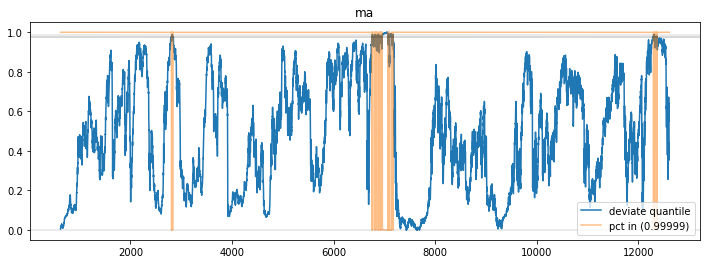

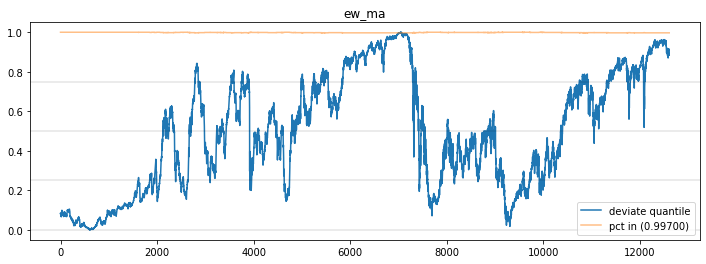

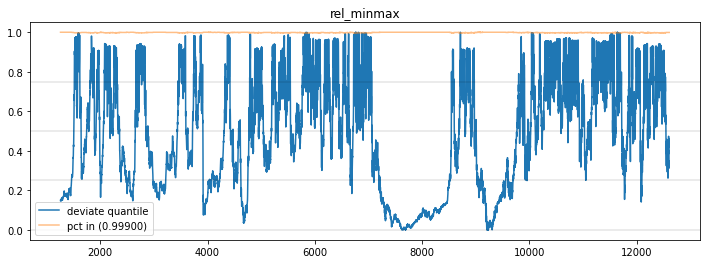

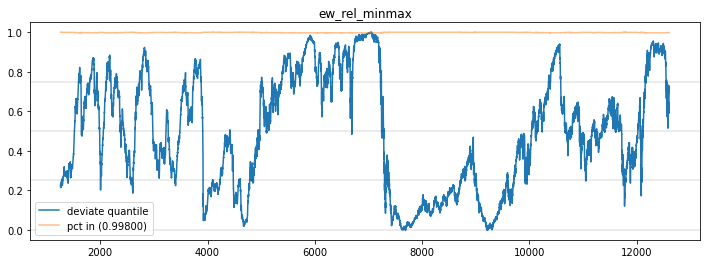

Saving ^IXIC params...



----------------------------------------------------------------------
                                 ^NYA
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 23.422241974195277
Refitting current best...
Current best ma returns: 30.02587823229422
Fraction Invested: 0.9999979919406592
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 23.422241974195277
Refitting current best...
Current best ew_ma returns: 32.4577824496471
Fraction Invested: 0.9999971737514832
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 180


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 23.422241974195277
Refitting current best...
Fraction Invested: 1


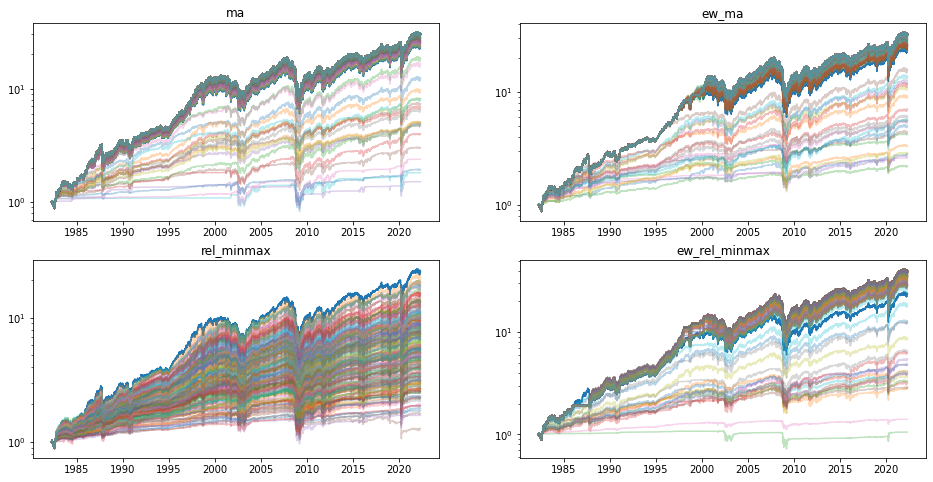

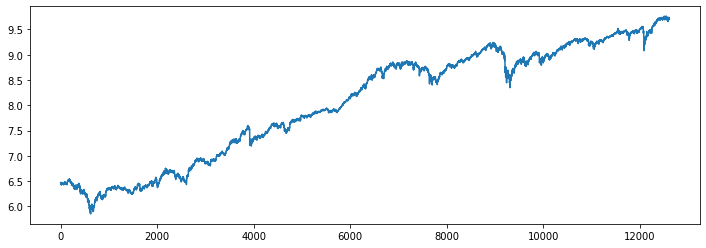

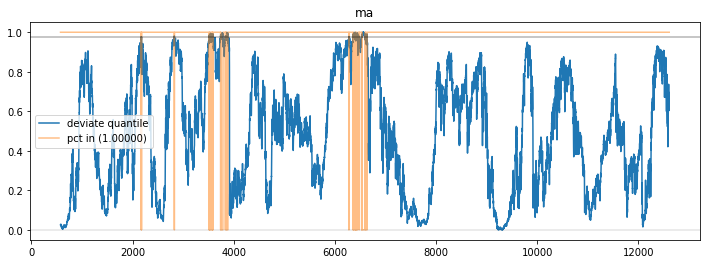

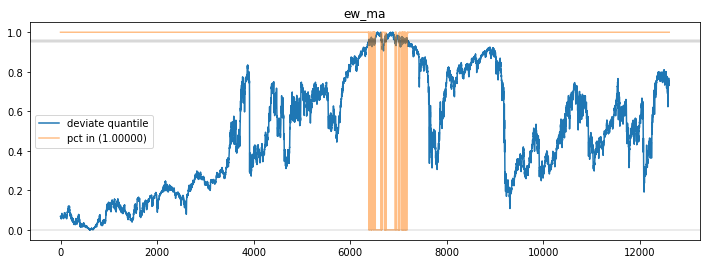

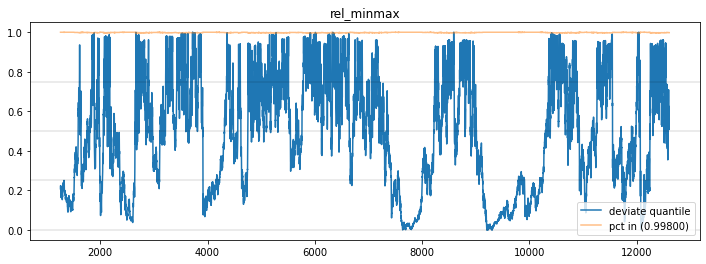

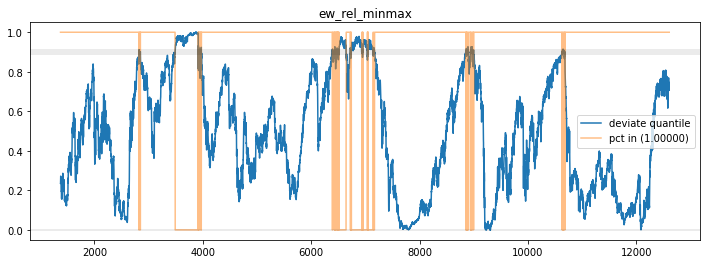

Saving ^NYA params...



----------------------------------------------------------------------
                                 ^W5000
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 7.937445315267407
Refitting current best...
Current best ma returns: 9.34042921577701
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 7.937445315267407
Refitting current best...
Current best ew_ma returns: 13.296679618350664
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 180


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 7.937445315267407
Refitting current best...
Current best rel_minmax returns: 8.23091954260584
Fr

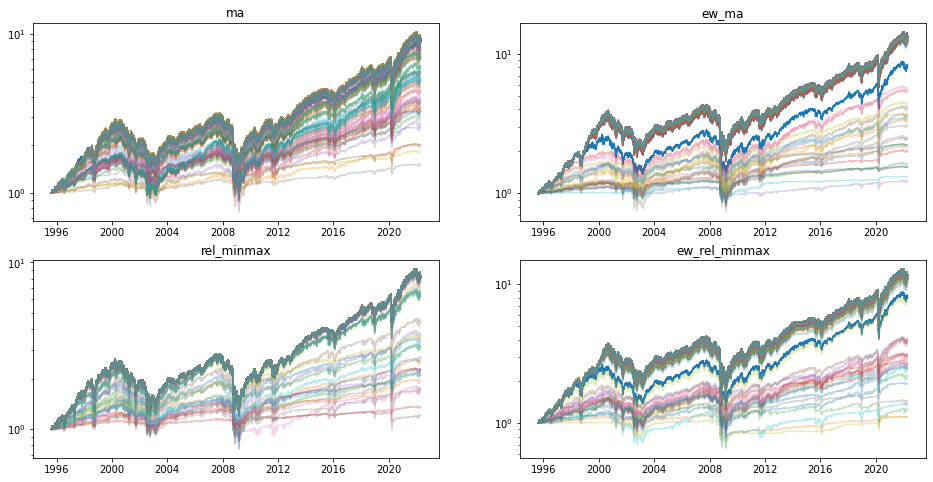

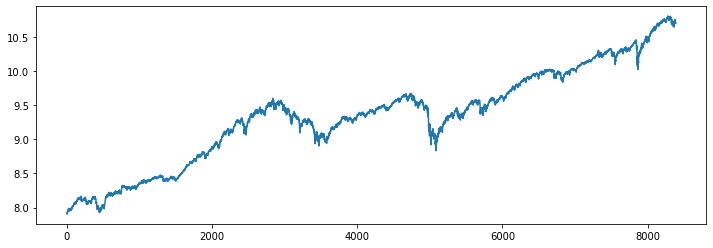

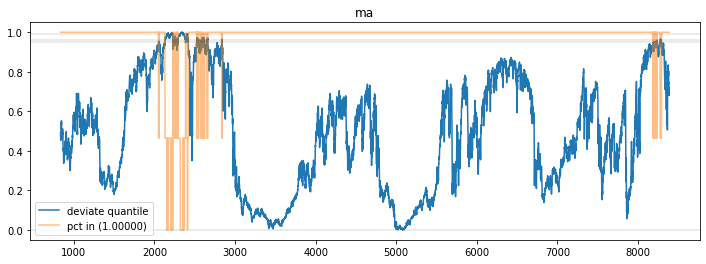

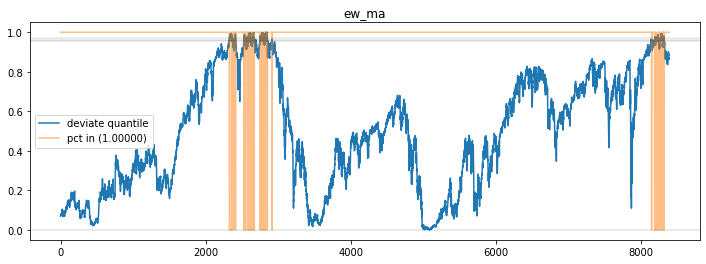

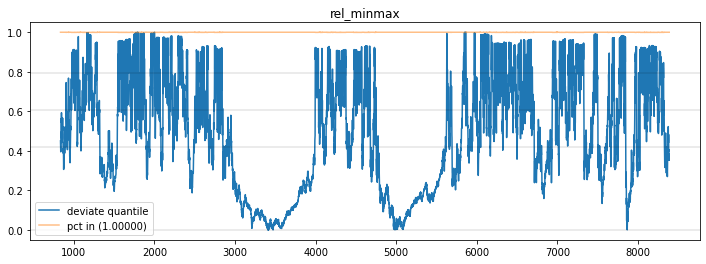

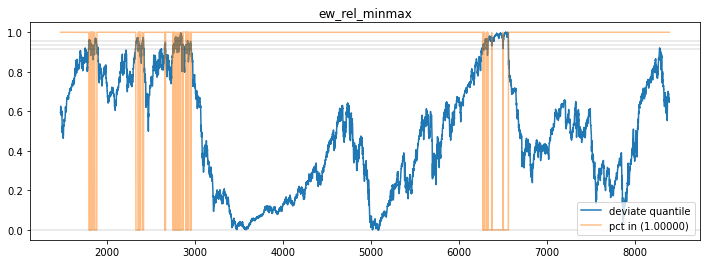

Saving ^W5000 params...



----------------------------------------------------------------------
                                 mine1
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 12.923478956244839
Refitting current best...
Current best ma returns: 14.287214898221285
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 12.923478956244839
Refitting current best...
Current best ew_ma returns: 15.139701828669667
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
New best: 15.139706321153218
Invested: 1.0
Round: 180


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 12.923478956244839
Refitting current best...
Fra

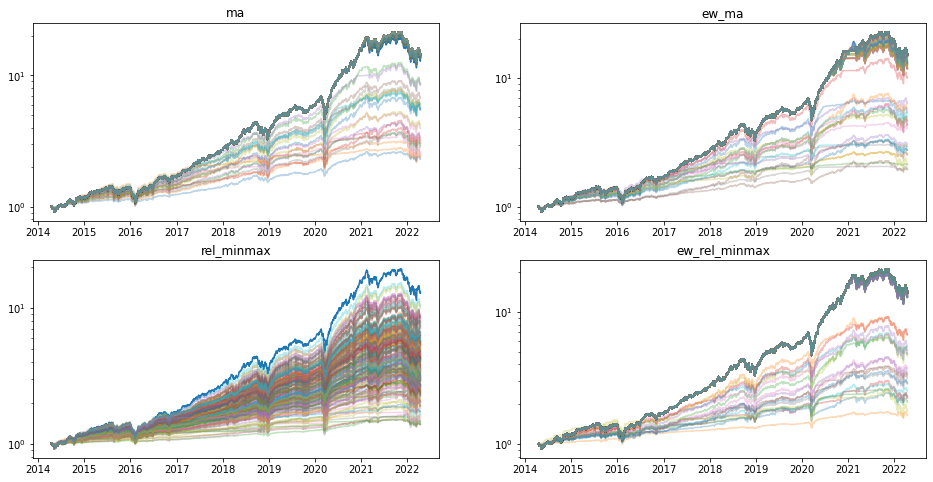

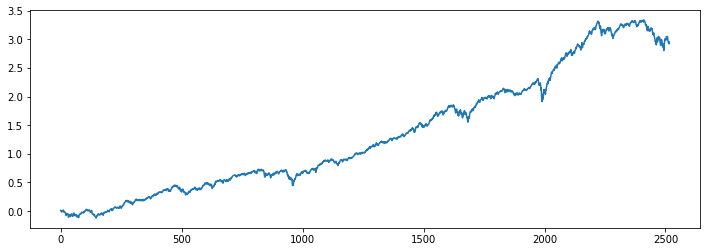

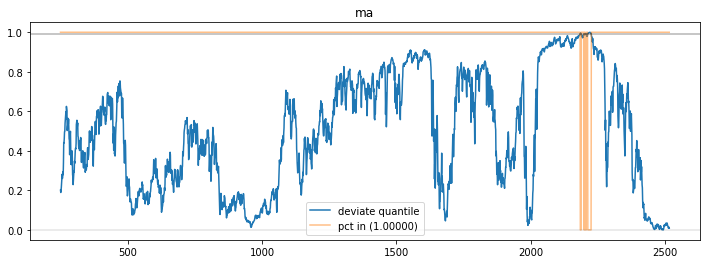

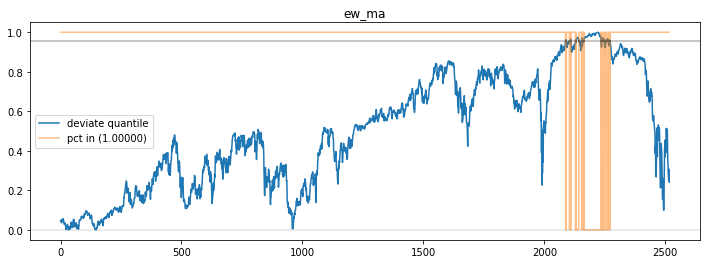

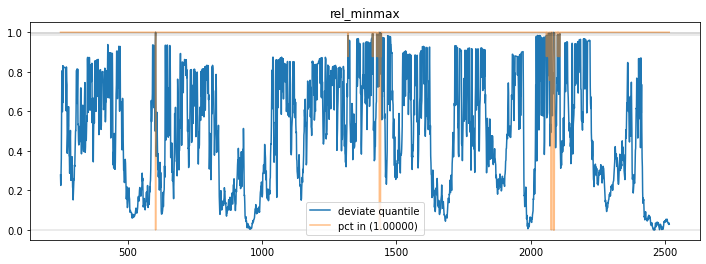

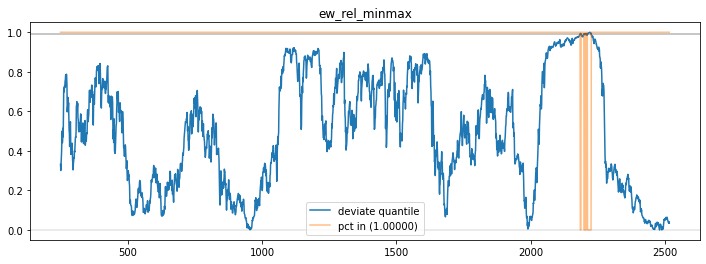

Saving mine1 params...



----------------------------------------------------------------------
                                 mine2
----------------------------------------------------------------------
Loaded current best.


Beginning ma method...
--------------------------------------------------
Do nothing returns: 4.938383252658185
Refitting current best...
Current best ma returns: 6.490964418047586
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 180


Beginning ew_ma method...
--------------------------------------------------
Do nothing returns: 4.938383252658185
Refitting current best...
Current best ew_ma returns: 7.352688354449803
Fraction Invested: 1.0
Beginning random search...
Round: 20
Beginning adjusted search...
Round: 180


Beginning rel_minmax method...
--------------------------------------------------
Do nothing returns: 4.938383252658185
Refitting current best...
Fraction Invested: 1
Beginning random search...
Roun

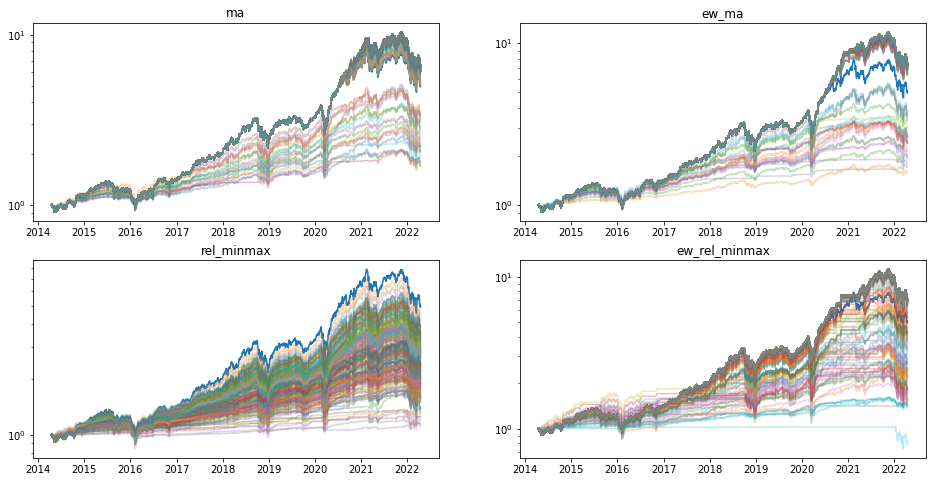

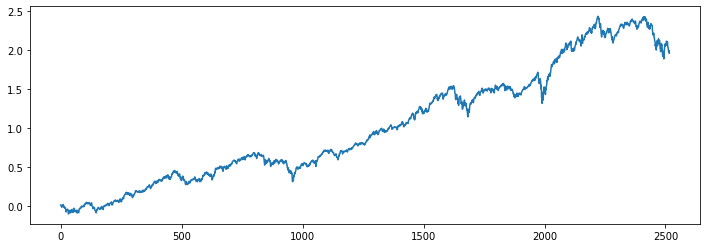

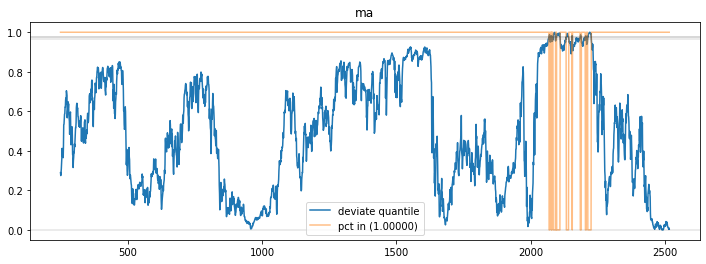

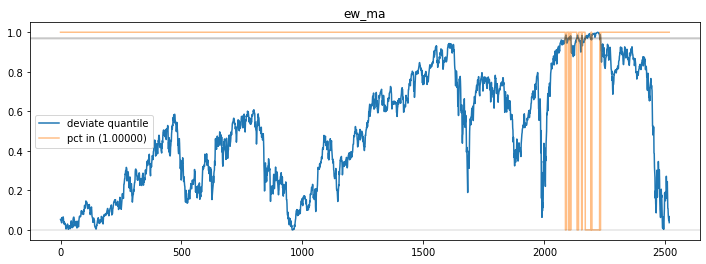

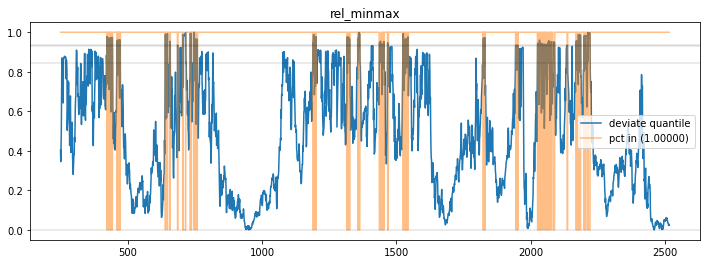

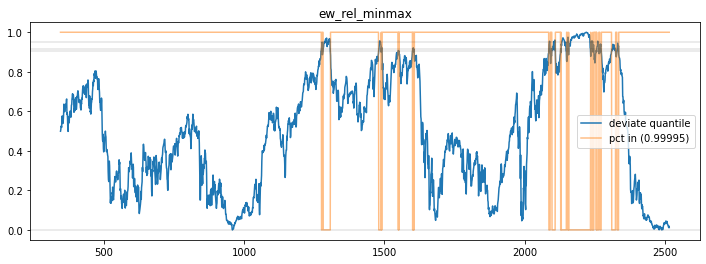

Saving mine2 params...


In [21]:
SD = 0.2213282
N_RAND = 20
N_ADJ = 180

#N_RAND = 5
#N_ADJ = 45

print('SD:', SD)
do_nothing_returns = {}
for stock in batch + ['mine1', 'mine2']: # 
    print('\n\n')
    print('-' * 70)
    print(' ' * 32, stock)
    print('-' * 70)
    try:
        best_params, best_returns = read_best_params(stock)
        stock_data = get_stock_data(stock, data)
        stock_data.fillna(method='ffill', inplace=True)
        stock_data.fillna(method='bfill', inplace=True)
        qp = QPercent(
            stock_data, 
            N_CUTS, 
            best_param_set=best_params, 
            best_returns=best_returns, 
            sd=SD)
        qp.run_sims(N_RAND, N_ADJ)
        ###
        for method in ['ma', 'ew_ma', 'rel_minmax', 'ew_rel_minmax']:
            qp.plot_best(method, stock=method == 'ma')
        ###
        best = get_best_param_set(qp)
        save_best_param_set(best, stock)
        do_nothing_returns[stock] = qp.do_nothing_returns
    except BaseException as e:
        print(f'Error encountered\n{e}')

In [22]:
def get_summary(stocks):
    best_returns = {}
    for stock in stocks:
        try:
            with open(f'{DATA}/{stock}_best_{N_YEARS}_years.json', 'r') as f:
                best = json.load(f)
            best_method = None
            best_return = 0
            best_pct = None
            for key in best:
                ret = best[key]['best_return']
                if ret > best_return:
                    best_return = ret
                    best_method = key
                    best_pct = best[key]['pct']
            print(f'\n{stock}:\n  Best Return: {best_return} '
                  f'({best_method})\n  {best_pct:.8f} in')
            data = best[best_method]
            print('time param:', data['time_param'])
            print('qs:')
            for rng, pct in data['q_params'].items():
                lower, upper = [float(x) for x in rng[1:-1].split(', ')]
                print(f'({lower:.4f} - {upper:.4f}): {pct:.4f}')
            best_returns[stock] = {'best_return': best_return, 'pct_in': best_pct}
        except FileNotFoundError:
            print('No data for', stock)
            continue
        except:
            print('Bad Data for', stock)
            continue
    return best_returns

In [23]:
ALL = SYMBOLS + INDICES
#get_summary(ALL)
best_returns = get_summary(batch + ['mine1', 'mine2'])
best_returns


^GSPC:
  Best Return: 71.65165052744126 (ew_rel_minmax)
  0.99999999 in
time param: 1668
qs:
(0.0000 - 0.9249): 1.0000
(0.9249 - 0.9340): 1.0000
(0.9340 - 0.9473): 0.9998
(0.9473 - 1.0000): 0.0005

^IXIC:
  Best Return: 112.93697788290159 (ma)
  0.99999253 in
time param: 626
qs:
(0.0000 - 0.9736): 1.0000
(0.9736 - 0.9782): 0.9996
(0.9782 - 0.9865): 0.0007
(0.9865 - 1.0000): 0.0000

^NYA:
  Best Return: 39.34299653844904 (ew_rel_minmax)
  0.99999986 in
time param: 1375
qs:
(0.0000 - 0.8877): 1.0000
(0.8877 - 0.8992): 1.0000
(0.8992 - 0.9109): 0.0003
(0.9109 - 1.0000): 0.0000

^W5000:
  Best Return: 13.296679618350664 (ew_ma)
  1.00000000 in
time param: 837
qs:
(0.0000 - 0.9579): 1.0000
(0.9579 - 0.9625): 1.0000
(0.9625 - 0.9712): 0.0003
(0.9712 - 1.0000): 0.0000

mine1:
  Best Return: 15.139706321153218 (ew_ma)
  1.00000000 in
time param: 251
qs:
(0.0000 - 0.9559): 1.0000
(0.9559 - 0.9561): 1.0000
(0.9561 - 0.9562): 0.9999
(0.9562 - 1.0000): 0.0001

mine2:
  Best Return: 7.352688354449

{'^GSPC': {'best_return': 71.65165052744126, 'pct_in': 0.9999999898484626},
 '^IXIC': {'best_return': 112.93697788290159, 'pct_in': 0.9999925274752438},
 '^NYA': {'best_return': 39.34299653844904, 'pct_in': 0.9999998637604431},
 '^W5000': {'best_return': 13.296679618350664, 'pct_in': 1.0},
 'mine1': {'best_return': 15.139706321153218, 'pct_in': 1.0},
 'mine2': {'best_return': 7.352688354449803, 'pct_in': 1.0}}

In [24]:
for stock in batch + ['mine1', 'mine2']:
    num = best_returns[stock]['best_return']
    den = do_nothing_returns[stock]
    weight = (num / den) - 1
    if weight <= 0:
        weight = 0
    if stock.startswith('mine'):
        weight /= 2
    best_returns[stock]['weight'] = weight
best_returns

{'^GSPC': {'best_return': 71.65165052744126,
  'pct_in': 0.9999999898484626,
  'weight': 0.8894117381800248},
 '^IXIC': {'best_return': 112.93697788290159,
  'pct_in': 0.9999925274752438,
  'weight': 0.5260908086998202},
 '^NYA': {'best_return': 39.34299653844904,
  'pct_in': 0.9999998637604431,
  'weight': 0.679728037213259},
 '^W5000': {'best_return': 13.296679618350664,
  'pct_in': 1.0,
  'weight': 0.6751837764192152},
 'mine1': {'best_return': 15.139706321153218,
  'pct_in': 1.0,
  'weight': 0.08574422461675701},
 'mine2': {'best_return': 7.352688354449803,
  'pct_in': 1.0,
  'weight': 0.24444286502997414}}

In [25]:
with open(f'{DATA}/qp_{N_YEARS}_weights.json', 'w') as f:
    json.dump(best_returns, f)

In [ ]:
!say qp 50 is dunzo

In [29]:
stop

NameError: name 'stop' is not defined

In [30]:
pcts_in = []
weights = []
# Get all weights combined
for years in [50, 40, 30, 20, 10, 5, 3]:
    try:
        with open(f'{DATA}/qp_{years}_weights.json', 'r') as f:
            weight_data = json.load(f)
        for stock, res in weight_data.items():
            pcts_in.append(res['pct_in'])
            weights.append(res['weight'])
    except FileNotFoundError:
        print('No data for', years)
    
for p, w in zip(pcts_in, weights):
    print(f'{p:.4f} ({w:.4f})')

1.0000 (0.8894)
1.0000 (0.5261)
1.0000 (0.6797)
1.0000 (0.6752)
1.0000 (0.0857)
1.0000 (0.2444)
1.0000 (0.7295)
0.9993 (0.3702)
0.9999 (0.7236)
1.0000 (0.6776)
1.0000 (0.0856)
1.0000 (0.2425)
1.0000 (0.2939)
1.0000 (0.3377)
1.0000 (0.6630)
1.0000 (0.5064)
1.0000 (0.0857)
1.0000 (0.1966)
1.0000 (0.0690)
1.0000 (0.2234)
1.0000 (0.2921)
0.0015 (0.2282)
1.0000 (0.0857)
1.0000 (0.2444)
1.0000 (0.1127)
1.0000 (0.1652)
1.0000 (0.0317)
1.0000 (0.1552)
1.0000 (0.0945)
1.0000 (0.2227)
1.0000 (0.1040)
1.0000 (0.2382)
1.0000 (0.1814)
1.0000 (0.0952)
1.0000 (0.0992)
1.0000 (0.1732)
1.0000 (0.1488)
1.0000 (0.2222)
1.0000 (0.1833)
0.9264 (0.1906)
1.0000 (0.0571)
1.0000 (0.2133)


In [31]:
ps = np.array(pcts_in)
ws = np.array(weights)
ws /= ws.sum()
np.dot(ps, ws)

0.9795461108053044